# Practica de Texto - Jorge Rivera y Rodrigo López de Toledo: Traductor Inglés - Español 

#### El objetivo de esta práctica es crear un traductor de inglés - español mediante la implementación de diferentes algoritmos de NLP.

####Se van a probar modelos empleando RNN simples, GRU y LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/Colab Notebooks/TEXT/LAB_TEXT_JORGERIVERA_RODRIGOLOPEZ

/content/drive/MyDrive/Colab Notebooks/TEXT/LAB_TEXT_JORGERIVERA_RODRIGOLOPEZ


In [ ]:
import string
import re
from numpy import array, argmax, random, take, arange
import numpy as np
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import backend as K
from keras import optimizers
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 250)


## Leer los Datos

Lo primero es leer los datos del dataset de Ingles a Español y separarlos entre frases en Ingles y frases en Español. El dataset está en Google Drive.

Para que el entrenamiento de los modelos tarde menos, no se va a trabajar con el dataset completo

In [ ]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

data = read_text("spa.txt")
eng_spa = to_lines(data)
eng_spa = array(eng_spa)

# Reducir el training size para que sea mas ágil el entrenamiento.
eng_spa = eng_spa[:50000,:]

## Pre-Procesado de los datos

Quitaremos los signos de puntuación y convertiremos todo a minúsculas.

In [ ]:
eng_spa

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest.', 'Agradezco tu interés.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

In [ ]:
# Remove punctuation
eng_spa[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_spa[:,0]]
eng_spa[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_spa[:,1]]
eng_spa

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1661151 (Amastan) & #1669102 (marcelostockle)'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933632 (CK) & #4788227 (DarkHollow)'],
       ['I appreciate your interest', 'Agradezco tu interés',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1933576 (CK) & #4394520 (teskmon)']],
      dtype='<U332')

In [ ]:
# convert to lowercase
for i in range(len(eng_spa)):
    eng_spa[i,0] = eng_spa[i,0].lower()
    eng_spa[i,1] = eng_spa[i,1].lower()

eng_spa = eng_spa[:,:2]
eng_spa

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer'],
       ['i appreciate all your help', 'aprecio toda tu ayuda'],
       ['i appreciate your interest', 'agradezco tu interés']],
      dtype='<U332')

## Convertir el dataset a formato Seq2Seq

Tenemos que convertir el dataset a secuencias de integers tanto para las frases en Alemán como las frases en Inglés (Output e Input)

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 2 columns]
8
12


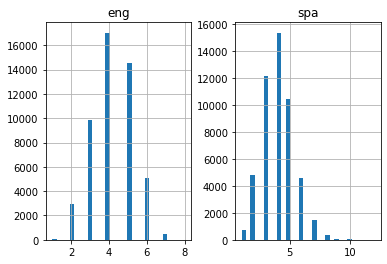

In [ ]:
# empty lists
eng = []
spa = []

# populate the lists with sentence lengths
for i in eng_spa[:,0]:
  eng.append(len(i.split()))

for i in eng_spa[:,1]:
  spa.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng, 'spa':spa})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

length_df.hist(bins = 30)
plt.show()

Ahora vectorizamos usando la clase Tokenizer(), que es lo que convertirá las frases a secuencias de integers. Ademas, añadirá un padding de zeros para que todas tengan la misma longitud.

In [ ]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

eng_tokenizer = tokenization(eng_spa[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 10
print('English Vocabulary Size: %d' % eng_vocab_size)

spa_tokenizer = tokenization(eng_spa[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 10
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

English Vocabulary Size: 6942
Spanish Vocabulary Size: 14196


## Model Building

Split de las secuencias y las codificamos como secuencias

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(eng_spa, test_size=0.2, random_state = 12)

# prepare training data
trainY = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

print(trainX.shape)
print(trainY.shape)

# prepare validation data
testY = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

print(testX.shape)
print(testY.shape)

(40000, 10)
(40000, 10)
(10000, 10)
(10000, 10)


### Modelo 1: Simple RNN

Empezamos probando una red RNN simple a ver si con un modelo muy simple los resultados son buenos.

Definimos la longitud estandar de la frases en 10, para asi coger casi todas las que hay, como se ve en los histogramas anteriores

In [ ]:
units = 64
rnn_1 = Sequential()
rnn_1.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
rnn_1.add(SimpleRNN(units))
rnn_1.add(RepeatVector(spa_length))
rnn_1.add(SimpleRNN(units,return_sequences=True))
rnn_1.add(Dense(spa_vocab_size, activation='softmax'))

rnn_1.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')
rnn_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 64)            444288    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                8256      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 64)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 64)            8256      
_________________________________________________________________
dense (Dense)                (None, 10, 14196)         922740    
Total params: 1,383,540
Trainable params: 1,383,540
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filename = 'rnn1.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_1 = rnn_1.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=50, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Epoch 1/50
500/500 [==============================] - 6s 13ms/step - loss: 2.7463 - val_loss: 2.7233

Epoch 00001: val_loss improved from inf to 2.72335, saving model to rnn1.h1
INFO:tensorflow:Assets written to: rnn1.h1/assets
Epoch 2/50
500/500 [==============================] - 6s 13ms/step - loss: 2.5741 - val_loss: 2.5739

Epoch 00002: val_loss improved from 2.72335 to 2.57394, saving model to rnn1.h1
INFO:tensorflow:Assets written to: rnn1.h1/assets
Epoch 3/50
500/500 [==============================] - 6s 13ms/step - loss: 2.4521 - val_loss: 2.4923

Epoch 00003: val_loss improved from 2.57394 to 2.49229, saving model to rnn1.h1
INFO:tensorflow:Assets written to: rnn1.h1/assets
Epoch 4/50
500/500 [==============================] - 7s 13ms/step - loss: 2.3619 - val_loss: 2.4271

Epoch 00004: val_loss improved from 2.49229 to 2.42707, saving model to rnn1.h1
INFO:tensorflow:Assets written to: rnn1.h1/assets
Epoch 5/50
500/500 [==============================] - 6s 13ms/step - loss: 2

In [ ]:
rnn_1.save('rnn_1.h5')

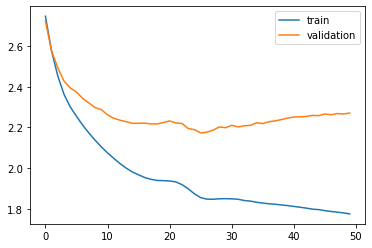

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Como se puede observar, con este modelo se obtiene un elevado overfitting. El resultado obtenido no es bueno.

In [ ]:
rnn1 = load_model('rnn1.h1')
preds = rnn1.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 250)
print("DONE")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


DONE


In [ ]:
pred_df.head(15)

,actual,predicted
0,ellos son muy optimistas,ellos son muy
1,conozco a tom,yo a tom
2,puedes negarte,puedes
3,eso es privado,eso es
4,tom saltó desde su asiento,tom es su mary
5,¿jamás has vendido un auto,¿has un vez un
6,¿cuántos hijos tienes,¿qué dos tienes
7,no te dejaré hacerlo,no lo que
8,¿no es hermoso,no es
9,mi loro murió ayer,ayer en ayer


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,¿tom y mary saben,mary a mary
9986,tom puede ser burdo,tom puede ser
9987,¿querés probarlo,¿quieres que
9988,¿sabes quién era,¿sabes quién que
9989,también es una belleza,ella es una buena
9990,quiero a su hija,me tu
9991,él da clases de inglés,él inglés
9992,me quedé dormido,me
9993,él es pobre como pocos,él es muy es un
9994,¿dónde está mi camisa,¿dónde está el llave


In [ ]:
pred_df.sample(15)

,actual,predicted
1574,¿dónde está mi reloj,¿dónde está mi trabajo
9933,tom me ayudó mucho,tom me ha mucho
5265,tom perdió la voz,tom perdió su
5715,¿vas a hacer eso,¿te si a
1328,¿no te gustó la película,no te la
712,¿puedes pasarme la sal,¿me en la
8605,tom parece estar feliz,tom parece estar ser
7397,no necesité contarle,no lo
5071,están solos,están
8164,no sea un cerdo,no es tan


El resultado no es bueno. De la teoría sabemos que RNN funciona bien cuando las frases son cortas. En el modelo hemos usado una longitud de 15. Vamos a probar una longitud de 5 ahora a ver si mejoran las traducciones

### Modelo 2: Simple RNN

Vamos a probar otra con longitud de frase 5 a ver si mejora el resultado. Además se añaden capas Dropout a ver si se corrige el overfitting anterior


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(eng_spa, test_size=0.2, random_state = 12)

spa_length = 5
eng_length = 5

# prepare training data
trainY = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

print(trainX.shape)
print(trainY.shape)

# prepare validation data
testY = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

print(testX.shape)
print(testY.shape)

(40000, 5)
(40000, 5)
(10000, 5)
(10000, 5)


In [ ]:
units = 64
rnn_2 = Sequential()
rnn_2.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
rnn_2.add(SimpleRNN(units))
rnn_2.add(Dropout(0.2))
rnn_2.add(RepeatVector(spa_length))
rnn_2.add(SimpleRNN(units,return_sequences=True))
rnn_2.add(Dropout(0.2))
rnn_2.add(Dense(spa_vocab_size, activation='softmax'))

rnn_2.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')
rnn_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 64)             444288    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 64)             0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 5, 64)             8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5, 14196)         

In [ ]:
filename = 'rnn2.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_2 = rnn_2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=50, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Epoch 1/50
500/500 [==============================] - 6s 9ms/step - loss: 6.3957 - val_loss: 5.3793

Epoch 00001: val_loss improved from inf to 5.37928, saving model to rnn2.h1
INFO:tensorflow:Assets written to: rnn2.h1/assets
Epoch 2/50
500/500 [==============================] - 4s 9ms/step - loss: 5.3025 - val_loss: 5.1509

Epoch 00002: val_loss improved from 5.37928 to 5.15086, saving model to rnn2.h1
INFO:tensorflow:Assets written to: rnn2.h1/assets
Epoch 3/50
500/500 [==============================] - 4s 9ms/step - loss: 5.0970 - val_loss: 4.9696

Epoch 00003: val_loss improved from 5.15086 to 4.96962, saving model to rnn2.h1
INFO:tensorflow:Assets written to: rnn2.h1/assets
Epoch 4/50
500/500 [==============================] - 5s 9ms/step - loss: 4.9425 - val_loss: 4.8512

Epoch 00004: val_loss improved from 4.96962 to 4.85118, saving model to rnn2.h1
INFO:tensorflow:Assets written to: rnn2.h1/assets
Epoch 5/50
500/500 [==============================] - 4s 9ms/step - loss: 4.8125

In [ ]:
rnn_2.save('rnn2.h5')

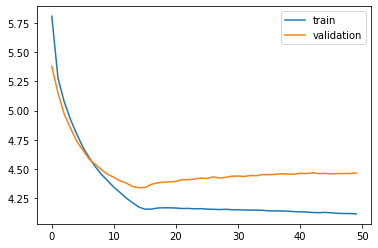

In [ ]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

En este caso hay menos overfitting que en el modelo 1, pero más error, más del doble de error.

In [ ]:
rnn2 = load_model('rnn2.h1')
preds = rnn2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1],spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 250)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
pred_df.head(15)

,actual,predicted
0,ellos son muy optimistas,ellos son muy
1,conozco a tom,me a
2,puedes negarte,te puedo
3,eso es privado,eso es
4,tom saltó desde su asiento,tom está en su
5,¿jamás has vendido un auto,puedes un libro
6,¿cuántos hijos tienes,¿por qué tienes
7,no te dejaré hacerlo,no lo
8,¿no es hermoso,no es
9,mi loro murió ayer,tom se está


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,¿tom y mary saben,tom a mary a mary
9986,tom puede ser burdo,tom puede ser
9987,¿querés probarlo,quiero que
9988,¿sabes quién era,sé que tom
9989,también es una belleza,él es un
9990,quiero a su hija,me tu
9991,él da clases de inglés,él estaba de
9992,me quedé dormido,me que
9993,él es pobre como pocos,no que
9994,¿dónde está mi camisa,¿dónde está mi


In [ ]:
pred_df.sample(15)

,actual,predicted
8730,no tenés futuro acá,no te en
2457,tom quería conocerles,tom quería
56,nos vamos de boston,estamos en a
1437,tokio es una ciudad enorme,es una grande
6424,te ves más joven que tom,que tom
7253,tom está bailando con mary,tom está con a mary
6316,todos los bondis están llenos,los son los
8403,las cosas pasan,bien
9020,tengo que peinarme el pelo,tengo que de mi
1121,pude oír todo,lo


Como se ve algunas traducciones funcionan bien pero ni son exactas ni la mayoría son buenas

### Modelo 3: GRU

Vamos a probar un par de modelos GRU para ver si mejora un poco la accuracy y la traducción.

Recordemos que GRU funciona bien con datasets pequeños.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(eng_spa, test_size=0.05, random_state = 12)

spa_length = 15
eng_length = 15

# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(spa_tokenizer, spa_length, train[:, 1])

print(trainX.shape)
print(trainY.shape)

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(spa_tokenizer, spa_length, test[:, 1])

print(testX.shape)
print(testY.shape)

(47500, 15)
(47500, 15)
(2500, 15)
(2500, 15)


In [ ]:
from keras.layers import GRU
units = 64
gru_1 = Sequential()
gru_1.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
gru_1.add(GRU(units))
gru_1.add(Dropout(0.2))
gru_1.add(RepeatVector(spa_length))
gru_1.add(GRU(units,return_sequences=True))
gru_1.add(Dropout(0.2))
gru_1.add(Dense(spa_vocab_size, activation='softmax'))

gru_1.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')
gru_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 15, 64)            444288    
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 15, 64)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 15, 64)            24960     
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 15, 14196)        

In [ ]:
filename = 'gru1.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_3 = gru_1.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=50, batch_size=units, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Epoch 1/50
500/500 [==============================] - 6s 13ms/step - loss: 2.0141 - val_loss: 1.9327

Epoch 00001: val_loss improved from inf to 1.93266, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 2/50
500/500 [==============================] - 5s 11ms/step - loss: 1.8971 - val_loss: 1.8813

Epoch 00002: val_loss improved from 1.93266 to 1.88134, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 3/50
500/500 [==============================] - 6s 11ms/step - loss: 1.8602 - val_loss: 1.8413

Epoch 00003: val_loss improved from 1.88134 to 1.84127, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 4/50
500/500 [==============================] - 5s 10ms/step - loss: 1.8170 - val_loss: 1.7985

Epoch 00004: val_loss improved from 1.84127 to 1.79846, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 5/50
500/500 [==============================] - 6s 11ms/step - loss: 1.7719 - val_loss: 1.7485

Epoch 00005: val_loss improved from 1.79846 to 1.74851, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 6/50
500/500 [==============================] - 6s 11ms/step - loss: 1.7328 - val_loss: 1.7150

Epoch 00006: val_loss improved from 1.74851 to 1.71504, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 7/50
500/500 [==============================] - 5s 11ms/step - loss: 1.6994 - val_loss: 1.6960

Epoch 00007: val_loss improved from 1.71504 to 1.69602, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 8/50
500/500 [==============================] - 6s 11ms/step - loss: 1.6682 - val_loss: 1.6607

Epoch 00008: val_loss improved from 1.69602 to 1.66072, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 9/50
500/500 [==============================] - 6s 11ms/step - loss: 1.6419 - val_loss: 1.6345

Epoch 00009: val_loss improved from 1.66072 to 1.63452, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 10/50
500/500 [==============================] - 6s 11ms/step - loss: 1.6173 - val_loss: 1.6185

Epoch 00010: val_loss improved from 1.63452 to 1.61850, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 11/50
500/500 [==============================] - 6s 11ms/step - loss: 1.5962 - val_loss: 1.6133

Epoch 00011: val_loss improved from 1.61850 to 1.61332, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 12/50
500/500 [==============================] - 6s 11ms/step - loss: 1.5761 - val_loss: 1.5863

Epoch 00012: val_loss improved from 1.61332 to 1.58632, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 13/50
500/500 [==============================] - 6s 11ms/step - loss: 1.5575 - val_loss: 1.5798

Epoch 00013: val_loss improved from 1.58632 to 1.57981, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 14/50
500/500 [==============================] - 5s 11ms/step - loss: 1.5397 - val_loss: 1.5693

Epoch 00014: val_loss improved from 1.57981 to 1.56928, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 15/50
500/500 [==============================] - 5s 11ms/step - loss: 1.5249 - val_loss: 1.5513

Epoch 00015: val_loss improved from 1.56928 to 1.55134, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 16/50
500/500 [==============================] - 6s 11ms/step - loss: 1.5122 - val_loss: 1.5417

Epoch 00016: val_loss improved from 1.55134 to 1.54170, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 17/50
500/500 [==============================] - 6s 11ms/step - loss: 1.5003 - val_loss: 1.5370

Epoch 00017: val_loss improved from 1.54170 to 1.53703, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 18/50
500/500 [==============================] - 5s 11ms/step - loss: 1.4908 - val_loss: 1.5364

Epoch 00018: val_loss improved from 1.53703 to 1.53639, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 19/50
500/500 [==============================] - 5s 11ms/step - loss: 1.4844 - val_loss: 1.5331

Epoch 00019: val_loss improved from 1.53639 to 1.53315, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 20/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4801 - val_loss: 1.5329

Epoch 00020: val_loss improved from 1.53315 to 1.53289, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 21/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4782 - val_loss: 1.5301

Epoch 00021: val_loss improved from 1.53289 to 1.53008, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 22/50
500/500 [==============================] - 5s 11ms/step - loss: 1.4763 - val_loss: 1.5371

Epoch 00022: val_loss did not improve from 1.53008
Epoch 23/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4763 - val_loss: 1.5369

Epoch 00023: val_loss did not improve from 1.53008
Epoch 24/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4748 - val_loss: 1.5369

Epoch 00024: val_loss did not improve from 1.53008
Epoch 25/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4730 - val_loss: 1.5391

Epoch 00025: val_loss did not improve from 1.53008
Epoch 26/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4689 - val_loss: 1.5397

Epoch 00026: val_loss did not improve from 1.53008
Epoch 27/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4670 - val_loss: 1.5369

Epoch 00027: val_loss did not improve from 1.53008
Epoch 28/50
500/500 [==============================] - 6s 11ms/step - loss: 

INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 32/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4486 - val_loss: 1.5283

Epoch 00032: val_loss improved from 1.52839 to 1.52832, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 33/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4456 - val_loss: 1.5266

Epoch 00033: val_loss improved from 1.52832 to 1.52664, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 34/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4427 - val_loss: 1.5268

Epoch 00034: val_loss did not improve from 1.52664
Epoch 35/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4399 - val_loss: 1.5234

Epoch 00035: val_loss improved from 1.52664 to 1.52335, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 36/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4361 - val_loss: 1.5224

Epoch 00036: val_loss improved from 1.52335 to 1.52237, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 37/50
500/500 [==============================] - 6s 12ms/step - loss: 1.4332 - val_loss: 1.5206

Epoch 00037: val_loss improved from 1.52237 to 1.52057, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 38/50
500/500 [==============================] - 6s 12ms/step - loss: 1.4297 - val_loss: 1.5190

Epoch 00038: val_loss improved from 1.52057 to 1.51895, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 39/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4276 - val_loss: 1.5200

Epoch 00039: val_loss did not improve from 1.51895
Epoch 40/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4241 - val_loss: 1.5154

Epoch 00040: val_loss improved from 1.51895 to 1.51543, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 41/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4218 - val_loss: 1.5158

Epoch 00041: val_loss did not improve from 1.51543
Epoch 42/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4191 - val_loss: 1.5150

Epoch 00042: val_loss improved from 1.51543 to 1.51495, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 43/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4166 - val_loss: 1.5155

Epoch 00043: val_loss did not improve from 1.51495
Epoch 44/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4139 - val_loss: 1.5117

Epoch 00044: val_loss improved from 1.51495 to 1.51167, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 45/50
500/500 [==============================] - 6s 12ms/step - loss: 1.4126 - val_loss: 1.5129

Epoch 00045: val_loss did not improve from 1.51167
Epoch 46/50
500/500 [==============================] - 6s 12ms/step - loss: 1.4096 - val_loss: 1.5084

Epoch 00046: val_loss improved from 1.51167 to 1.50840, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 47/50
500/500 [==============================] - 6s 11ms/step - loss: 1.4076 - val_loss: 1.5093

Epoch 00047: val_loss did not improve from 1.50840
Epoch 48/50
500/500 [==============================] - 6s 12ms/step - loss: 1.4051 - val_loss: 1.5088

Epoch 00048: val_loss did not improve from 1.50840
Epoch 49/50
500/500 [==============================] - 6s 12ms/step - loss: 1.4031 - val_loss: 1.5070

Epoch 00049: val_loss improved from 1.50840 to 1.50695, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


Epoch 50/50
500/500 [==============================] - 6s 12ms/step - loss: 1.3995 - val_loss: 1.5065

Epoch 00050: val_loss improved from 1.50695 to 1.50648, saving model to gru1.h1


INFO:tensorflow:Assets written to: gru1.h1/assets


INFO:tensorflow:Assets written to: gru1.h1/assets


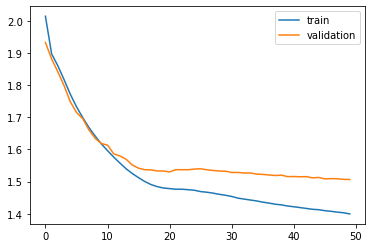

In [ ]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Este modelo hasta ahora es el mejor de los que se ha probado, se ve claramente como con este modelo, tanto el overfitting como el loss se reduce bastante, obteniendo unos mejores resultados

In [ ]:
gru1 = load_model('gru1.h1')
preds = gru1.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 250)

In [ ]:
pred_df.sample(15)

,actual,predicted
1883,me quedaré cerca,me a
2321,ésta es su casa,esta es su casa
696,tom estaba desorientado,tom estaba
962,¿puedo traerte un café,¿puedo que un
1811,tom es muy viejo,tom es muy
959,les estoy agradecido,estoy de
594,tom nunca la volvió a ver,tom nunca hizo un nunca
1949,dame tiempo,
1679,esta tarea es difícil,esta libro es
108,trabajamos todos juntos,todos


En cuanto a las predicciones son un poco mejores pero no son ninguna maravilla

### Modelo 4: GRU

Vamos a probar un segundo modelo GRU a ver si mejora. Lo haremos incrementando las capas de la red, para tener mas recursividad, a ver si la precisiond de la traducción sube un poco

In [ ]:
from keras.layers import GRU
units = 64
gru_2 = Sequential()
gru_2.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True))
gru_2.add(GRU(units))
gru_2.add(Dropout(0.2))
gru_2.add(RepeatVector(spa_length))
gru_2.add(GRU(units,return_sequences=True))
gru_2.add(GRU(units,return_sequences=True))
gru_2.add(GRU(units,return_sequences=True))
gru_2.add(Dropout(0.2))
gru_2.add(Dense(spa_vocab_size, activation='softmax'))

gru_2.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')
gru_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 15, 64)            444288    
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 15, 64)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 15, 64)            24960     
_________________________________________________________________
gru_8 (GRU)                  (None, 15, 64)            24960     
_________________________________________________________________
gru_9 (GRU)                  (None, 15, 64)           

In [ ]:
filename = 'gru2.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_4 = gru_2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                           epochs=50, batch_size=32, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Epoch 1/50
1188/1188 [==============================] - 27s 16ms/step - loss: 2.7589 - val_loss: 1.9226

Epoch 00001: val_loss improved from inf to 1.92264, saving model to gru2.h1


INFO:tensorflow:Assets written to: gru2.h1/assets


INFO:tensorflow:Assets written to: gru2.h1/assets


Epoch 2/50
1188/1188 [==============================] - 17s 15ms/step - loss: 1.8992 - val_loss: 1.8437

Epoch 00002: val_loss improved from 1.92264 to 1.84372, saving model to gru2.h1


INFO:tensorflow:Assets written to: gru2.h1/assets


INFO:tensorflow:Assets written to: gru2.h1/assets


Epoch 3/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.8366 - val_loss: 1.8033

Epoch 00003: val_loss improved from 1.84372 to 1.80326, saving model to gru2.h1


INFO:tensorflow:Assets written to: gru2.h1/assets


INFO:tensorflow:Assets written to: gru2.h1/assets


Epoch 4/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.7940 - val_loss: 1.7520

Epoch 00004: val_loss improved from 1.80326 to 1.75203, saving model to gru2.h1


INFO:tensorflow:Assets written to: gru2.h1/assets


INFO:tensorflow:Assets written to: gru2.h1/assets


Epoch 5/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.7496 - val_loss: 1.7333

Epoch 00005: val_loss improved from 1.75203 to 1.73331, saving model to gru2.h1


INFO:tensorflow:Assets written to: gru2.h1/assets


INFO:tensorflow:Assets written to: gru2.h1/assets


Epoch 6/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.7102 - val_loss: 1.6832

Epoch 00006: val_loss improved from 1.73331 to 1.68321, saving model to gru2.h1


INFO:tensorflow:Assets written to: gru2.h1/assets


INFO:tensorflow:Assets written to: gru2.h1/assets


Epoch 7/50
1188/1188 [==============================] - 17s 15ms/step - loss: 1.6688 - val_loss: 1.6539

Epoch 00007: val_loss improved from 1.68321 to 1.65385, saving model to gru2.h1


INFO:tensorflow:Assets written to: gru2.h1/assets


INFO:tensorflow:Assets written to: gru2.h1/assets


Epoch 8/50
1188/1188 [==============================] - 17s 15ms/step - loss: 1.6433 - val_loss: 1.6199

Epoch 00008: val_loss improved from 1.65385 to 1.61994, saving model to gru2.h1


INFO:tensorflow:Assets written to: gru2.h1/assets


INFO:tensorflow:Assets written to: gru2.h1/assets


Epoch 9/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.6073 - val_loss: 1.6048

Epoch 00009: val_loss improved from 1.61994 to 1.60480, saving model to gru2.h1


INFO:tensorflow:Assets written to: gru2.h1/assets


INFO:tensorflow:Assets written to: gru2.h1/assets


Epoch 10/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.6047 - val_loss: 1.6420

Epoch 00010: val_loss did not improve from 1.60480
Epoch 11/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.6424 - val_loss: 1.7010

Epoch 00011: val_loss did not improve from 1.60480
Epoch 12/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.6583 - val_loss: 1.6956

Epoch 00012: val_loss did not improve from 1.60480
Epoch 13/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.6657 - val_loss: 1.6960

Epoch 00013: val_loss did not improve from 1.60480
Epoch 14/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.6559 - val_loss: 1.6916

Epoch 00014: val_loss did not improve from 1.60480
Epoch 15/50
1188/1188 [==============================] - 18s 15ms/step - loss: 1.6538 - val_loss: 1.6858

Epoch 00015: val_loss did not improve from 1.60480
Epoch 16/50
1188/1188 [==============================] - 1

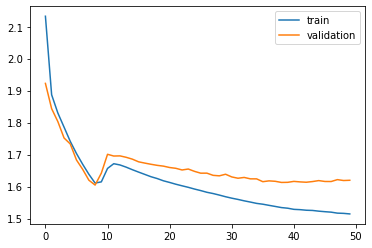

In [ ]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Los resultados obtenidos en este paso son muy similares a los obtenidos con el otro modelo de GRU

In [ ]:
gru2 = load_model('gru2.h1')
preds = gru2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 250)

In [ ]:
pred_df.sample(15)

,actual,predicted
448,eso no tiene interés,eso no es
1608,tom no es una mala persona,tom no es un
966,seamos felices,¿puedes
483,deja de quejarte,¿estás de
2162,no la escuches,no me
269,lo sabemos,lo esto
755,esto sería un error,ella tiene un
2450,mi salario es muy bajo,el perro es muy
1179,aún no se lo he contado a tom,no me que a tom
1283,lo digo totalmente en serio,estoy de


Las predicciones siguen siendo bastante regulares

### Modelo 5: LSTM

Por último probaremos LSTMs las redes que son mas potentes. Son mas lentas que GRU, pero deberían arrojar mejores resultados

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(eng_spa, test_size=0.1, random_state = 12)

# prepare training data
trainY = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

print(trainX.shape)
print(trainY.shape)

# prepare validation data
testY = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

print(testX.shape)
print(testY.shape)

(45000, 10)
(45000, 10)
(5000, 10)
(5000, 10)


In [ ]:
from keras import layers

units = 512
    
lstm_1 = Sequential()
lstm_1.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True)) #mask_zero es para rellenar con padding si la longitud de la entrada es variable
lstm_1.add(LSTM(512, return_sequences=True))
lstm_1.add(layers.Dropout(0.3))
#lstm_1.add(RepeatVector(spa_length))
lstm_1.add(LSTM(512, return_sequences=True))
lstm_1.add(layers.Dropout(0.2))
lstm_1.add(TimeDistributed(Dense(spa_vocab_size)))
lstm_1.add(layers.Activation('softmax'))

lstm_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 512)           3554304   
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 512)           2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 14196)         7282548   
_________________________________________________________________
activation_1 (Activation)    (None, 10, 14196)        

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
lstm_1.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

filename = 'lstm1.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_5 = lstm_1.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=20, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
282/282 [==============================] - 17s 39ms/step - loss: 2.7436 - val_loss: 2.2629

Epoch 00001: val_loss improved from inf to 2.26292, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 2/20
282/282 [==============================] - 9s 33ms/step - loss: 2.1457 - val_loss: 2.0509

Epoch 00002: val_loss improved from 2.26292 to 2.05091, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 3/20
282/282 [==============================] - 10s 36ms/step - loss: 1.9581 - val_loss: 1.9564

Epoch 00003: val_loss improved from 2.05091 to 1.95644, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 4/20
282/282 [==============================] - 9s 32ms/step - loss: 1.8486 - val_loss: 1.9030

Epoch 00004: val_loss improved from 1.95644 to 1.90301, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 5/20
282/282 [==============================] - 9s 33ms/step - loss: 1.7694 - val_loss: 1.8456

Epoch 00005: val_loss improved from 1.90301 to 1.84561, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 6/20
282/282 [==============================] - 9s 32ms/step - loss: 1.6953 - val_loss: 1.8140

Epoch 00006: val_loss improved from 1.84561 to 1.81396, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 7/20
282/282 [==============================] - 9s 33ms/step - loss: 1.6495 - val_loss: 1.7842

Epoch 00007: val_loss improved from 1.81396 to 1.78416, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 8/20
282/282 [==============================] - 9s 32ms/step - loss: 1.6030 - val_loss: 1.7617

Epoch 00008: val_loss improved from 1.78416 to 1.76170, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 9/20
282/282 [==============================] - 9s 33ms/step - loss: 1.5617 - val_loss: 1.7518

Epoch 00009: val_loss improved from 1.76170 to 1.75180, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 10/20
282/282 [==============================] - 9s 33ms/step - loss: 1.5250 - val_loss: 1.7344

Epoch 00010: val_loss improved from 1.75180 to 1.73436, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 11/20
282/282 [==============================] - 9s 33ms/step - loss: 1.4975 - val_loss: 1.7286

Epoch 00011: val_loss improved from 1.73436 to 1.72858, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 12/20
282/282 [==============================] - 9s 33ms/step - loss: 1.4723 - val_loss: 1.7279

Epoch 00012: val_loss improved from 1.72858 to 1.72790, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 13/20
282/282 [==============================] - 9s 33ms/step - loss: 1.4393 - val_loss: 1.7189

Epoch 00013: val_loss improved from 1.72790 to 1.71891, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 14/20
282/282 [==============================] - 9s 32ms/step - loss: 1.4194 - val_loss: 1.7143

Epoch 00014: val_loss improved from 1.71891 to 1.71430, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 15/20
282/282 [==============================] - 9s 33ms/step - loss: 1.4049 - val_loss: 1.7104

Epoch 00015: val_loss improved from 1.71430 to 1.71040, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 16/20
282/282 [==============================] - 9s 33ms/step - loss: 1.3816 - val_loss: 1.7101

Epoch 00016: val_loss improved from 1.71040 to 1.71012, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 17/20
282/282 [==============================] - 9s 32ms/step - loss: 1.3628 - val_loss: 1.7075

Epoch 00017: val_loss improved from 1.71012 to 1.70750, saving model to lstm1.h1


INFO:tensorflow:Assets written to: lstm1.h1/assets


INFO:tensorflow:Assets written to: lstm1.h1/assets


Epoch 18/20
282/282 [==============================] - 9s 33ms/step - loss: 1.3510 - val_loss: 1.7077

Epoch 00018: val_loss did not improve from 1.70750
Epoch 19/20
282/282 [==============================] - 9s 32ms/step - loss: 1.3321 - val_loss: 1.7115

Epoch 00019: val_loss did not improve from 1.70750
Epoch 20/20
282/282 [==============================] - 9s 33ms/step - loss: 1.3225 - val_loss: 1.7114

Epoch 00020: val_loss did not improve from 1.70750


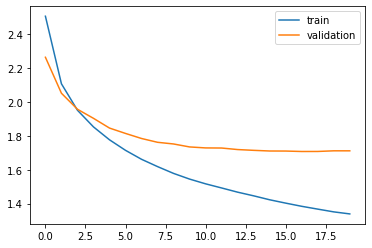

In [ ]:
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Al utilizar LSTM tampoco se consigue una gran mejora, los resultados son parecidos al modelo de GRU

In [ ]:
lstm1 = load_model('lstm1.h1')
preds = lstm1.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)
pred_df.head(15)

,actual,predicted
0,ellos son muy optimistas,ellos son muy
1,conozco a tom,no que tom
2,puedes negarte,no puedes llamar
3,eso es privado,eso es
4,tom saltó desde su asiento,tom terminó de su
5,¿jamás has vendido un auto,¿has visto has vez un coche
6,¿cuántos hijos tienes,¿cómo libros tienes
7,no te dejaré hacerlo,no a
8,¿no es hermoso,¿no es hermosa
9,mi loro murió ayer,mi duele murió en


In [ ]:
pred_df.sample(15)

,actual,predicted
1435,él le dijo que estudiara,él me dijo que fuera
3686,la asistencia es obligatoria,los es
2558,écheme la mano,ayúdame a salir
3536,¿puedo ponerlo aquí,¿puedo puedo aquí
3195,¿qué fecha es hoy,¿qué es el
1619,a menudo no hago las cosas bien,no menudo a los cosas
569,llegará lejos,te a
3761,estamos acá,estamos aquí
4099,el valor predeterminado es cero,la guerra le está
767,tom está loco,tom está


Las predicciones siguen siendo no muy buenas

### Modelo 6: LSTM

Vamos a probar otra estructura de LSTMs. Vamos a incrementar el numero de palabras, para poder hacer uso de la mayor capacidad de memoria de LSTM, subir las iteraciones y añadir unas capas mas.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(eng_spa, test_size=0.05, random_state = 12)

eng_length = 20
spa_length = 20

# prepare training data
trainY = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

print(trainX.shape)
print(trainY.shape)

# prepare validation data
testY = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

print(testX.shape)
print(testY.shape)

(47500, 20)
(47500, 20)
(2500, 20)
(2500, 20)


In [ ]:
from keras import layers

units = 512
    
lstm_2 = Sequential()
lstm_2.add(Embedding(eng_vocab_size, units, input_length=eng_length, mask_zero=True)) #mask_zero es para rellenar con padding si la longitud de la entrada es variable
lstm_2.add(LSTM(512, return_sequences=True))
lstm_2.add(layers.Dropout(0.3))
#lstm_2.add(RepeatVector(spa_length))
lstm_2.add(LSTM(512, return_sequences=True))
lstm_2.add(LSTM(512, return_sequences=True))
lstm_2.add(LSTM(512, return_sequences=True))
lstm_2.add(layers.Dropout(0.2))
lstm_2.add(TimeDistributed(Dense(spa_vocab_size)))
lstm_2.add(layers.Activation('softmax'))

lstm_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 512)           3554304   
_________________________________________________________________
lstm (LSTM)                  (None, 20, 512)           2099200   
_________________________________________________________________
dropout (Dropout)            (None, 20, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 512)           0

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
lstm_2.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

filename = 'lstm2.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_6 = lstm_2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=40, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/40
297/297 [==============================] - 46s 66ms/step - loss: 1.3652 - val_loss: 1.1853

Epoch 00001: val_loss improved from inf to 1.18533, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 2/40
297/297 [==============================] - 16s 53ms/step - loss: 1.1435 - val_loss: 1.1050

Epoch 00002: val_loss improved from 1.18533 to 1.10499, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 3/40
297/297 [==============================] - 16s 53ms/step - loss: 1.0600 - val_loss: 1.0402

Epoch 00003: val_loss improved from 1.10499 to 1.04019, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 4/40
297/297 [==============================] - 16s 53ms/step - loss: 0.9979 - val_loss: 0.9998

Epoch 00004: val_loss improved from 1.04019 to 0.99977, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 5/40
297/297 [==============================] - 16s 53ms/step - loss: 0.9498 - val_loss: 0.9696

Epoch 00005: val_loss improved from 0.99977 to 0.96962, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 6/40
297/297 [==============================] - 16s 52ms/step - loss: 0.9090 - val_loss: 0.9455

Epoch 00006: val_loss improved from 0.96962 to 0.94549, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 7/40
297/297 [==============================] - 16s 52ms/step - loss: 0.8794 - val_loss: 0.9268

Epoch 00007: val_loss improved from 0.94549 to 0.92678, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 8/40
297/297 [==============================] - 15s 52ms/step - loss: 0.8483 - val_loss: 0.9154

Epoch 00008: val_loss improved from 0.92678 to 0.91536, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 9/40
297/297 [==============================] - 15s 52ms/step - loss: 0.8220 - val_loss: 0.9005

Epoch 00009: val_loss improved from 0.91536 to 0.90051, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 10/40
297/297 [==============================] - 15s 52ms/step - loss: 0.7968 - val_loss: 0.8947

Epoch 00010: val_loss improved from 0.90051 to 0.89474, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 11/40
297/297 [==============================] - 15s 52ms/step - loss: 0.7808 - val_loss: 0.8861

Epoch 00011: val_loss improved from 0.89474 to 0.88610, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 12/40
297/297 [==============================] - 16s 53ms/step - loss: 0.7595 - val_loss: 0.8825

Epoch 00012: val_loss improved from 0.88610 to 0.88250, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 13/40
297/297 [==============================] - 16s 53ms/step - loss: 0.7408 - val_loss: 0.8768

Epoch 00013: val_loss improved from 0.88250 to 0.87678, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 14/40
297/297 [==============================] - 16s 53ms/step - loss: 0.7259 - val_loss: 0.8752

Epoch 00014: val_loss improved from 0.87678 to 0.87525, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 15/40
297/297 [==============================] - 16s 53ms/step - loss: 0.7097 - val_loss: 0.8757

Epoch 00015: val_loss did not improve from 0.87525
Epoch 16/40
297/297 [==============================] - 16s 53ms/step - loss: 0.6950 - val_loss: 0.8751

Epoch 00016: val_loss improved from 0.87525 to 0.87510, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 17/40
297/297 [==============================] - 16s 53ms/step - loss: 0.6824 - val_loss: 0.8751

Epoch 00017: val_loss improved from 0.87510 to 0.87510, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 18/40
297/297 [==============================] - 16s 53ms/step - loss: 0.6711 - val_loss: 0.8755

Epoch 00018: val_loss did not improve from 0.87510
Epoch 19/40
297/297 [==============================] - 16s 52ms/step - loss: 0.6621 - val_loss: 0.8767

Epoch 00019: val_loss did not improve from 0.87510
Epoch 20/40
297/297 [==============================] - 16s 53ms/step - loss: 0.6447 - val_loss: 0.8744

Epoch 00020: val_loss improved from 0.87510 to 0.87444, saving model to lstm2.h1


INFO:tensorflow:Assets written to: lstm2.h1/assets


INFO:tensorflow:Assets written to: lstm2.h1/assets


Epoch 21/40
297/297 [==============================] - 16s 53ms/step - loss: 0.6340 - val_loss: 0.8756

Epoch 00021: val_loss did not improve from 0.87444
Epoch 22/40
297/297 [==============================] - 16s 53ms/step - loss: 0.6266 - val_loss: 0.8769

Epoch 00022: val_loss did not improve from 0.87444
Epoch 23/40
297/297 [==============================] - 16s 52ms/step - loss: 0.6218 - val_loss: 0.8841

Epoch 00023: val_loss did not improve from 0.87444
Epoch 24/40
297/297 [==============================] - 16s 52ms/step - loss: 0.6133 - val_loss: 0.8824

Epoch 00024: val_loss did not improve from 0.87444
Epoch 25/40
297/297 [==============================] - 16s 53ms/step - loss: 0.6056 - val_loss: 0.8841

Epoch 00025: val_loss did not improve from 0.87444
Epoch 26/40
297/297 [==============================] - 16s 53ms/step - loss: 0.5970 - val_loss: 0.8913

Epoch 00026: val_loss did not improve from 0.87444
Epoch 27/40
297/297 [==============================] - 16s 52ms/step -

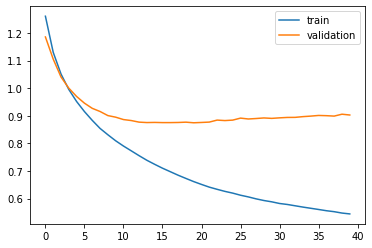

In [ ]:
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Con este último modelo se ha conseguido reducir el error pero presenta un gran overfitting, tampoco es un buen resultado

In [ ]:
lstm2 = load_model('lstm2.h1')
preds = lstm2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], spa_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], spa_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)
pred_df.head(15)

,actual,predicted
0,ellos son muy optimistas,ellos son muy
1,conozco a tom,no que tom
2,puedes negarte,no puedes un
3,eso es privado,eso es
4,tom saltó desde su asiento,tom apagó lentamente su sus
5,¿jamás has vendido un auto,¿has visto alguna un coche
6,¿cuántos hijos tienes,¿cómo libros
7,no te dejaré hacerlo,no voy a
8,¿no es hermoso,¿no es suficiente
9,mi loro murió ayer,mi duele murió ayer


In [ ]:
pred_df.sample(15)

,actual,predicted
1945,soy la prima de tom,estoy la médico
2445,este periódico es gratuito,esto sitio es mía
1766,tom tiene una familia grande,tom tiene un gran grande
1424,me ha cobrado de más,no
267,se escondió detrás de la puerta,él se detrás de
366,el examen fue fácil,el fiesta estaba fácil
593,por favor déjame ir,por ir por ir
2109,a nadie le gusta mi país,nadie mi esposa
34,soy bueno,no estoy
404,seguí caminando hacia el coche,no mi


Claramente las predicciones obtenidas no son buenas

### Conclusiones

A pesar de probar seis modelos diferentes con tres técnicas distintas, los resultados obtenidos no son muy satisfactorios al no conseguir unas buenas predicciones con ninguno de los modelos.

Con un tamaño de vocabulario más grande, se podrían haber conseguido unos mejores resultados seguramente.